In [1]:
import itertools
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import seaborn as sns
import tqdm
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.scaler import STMatrixStandardScaler
from utils.helper import format_stmatrix, train_test_split, fix_seed
from dataset import STDataset
# from trainer import Trainer
from logger import Logger
from modules import Embedding_Conv2dLSTM
import config

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=3)

## 前処理してデータセットを作成
- 渋滞量 -> フラグに変換
- 方向 -> 0/1に変換
    - 上り: 0, 下り: 1
- 四半期を数値化
- 使用しないカラムを落とす
    - 天気 + `index`, `data`, `road_code`, `jam_type`
- 速度の欠損を埋める
- OCC -> [0, 1]に変換
- 型変換
    - float64 -> float32
    - 区間の名前, コード, 県コード, 0/1系, カレンダーデータをcategoryデータに
    - degreeをint32

In [4]:
# 道路名
# TARGET_ROAD='tateyama'
TARGET_ROAD='kannetsu'

# 交通量
PROCESSED_DATA_DIR = '../Input_processed_data'
TRAFFIC_DIR = f'{PROCESSED_DATA_DIR}/traffic'
TRAFFIC_CSV = f'{TRAFFIC_DIR}/{TARGET_ROAD}_20220621all-merged_filled_1h.csv'

In [5]:
col_types = {'start_code': str, 'end_code': str, 'road_code': str, 'jam_type': str,}

df = pd.read_csv(TRAFFIC_CSV, parse_dates=True, index_col='datetime', dtype=col_types).reset_index()

In [7]:
def linear_interpolate(df, col):
    '''
    dfのcolカラム内の欠損を区間ごとに線形補間する
    '''
    f = lambda g: g.interpolate(method='linear', axis=0)
    
    df.sort_values('datetime', inplace=True)
    df[col] = df.groupby(['start_code', 'end_code'])[col].apply(f)
    return df


def preprocess(df):
    # 「年」情報を入れる
    df['year'] = df['datetime'].dt.year
    # 渋滞フラグ 0/1
    df['jam_quantity'] = np.where(df['speed'] < 40, 1, 0)
    # 方向を数値化
    direction_map = {'上り': 0, '下り': 1}
    df['direction'] = df['direction'].map(direction_map)
    # 四半期を数値化
    df['quarter'] = df['quarter'].str[-1]
    
    # object型のカラム, いらないカラムを落とす
    drop_cols = [
        'index', 'date', 'road_code', 'pressure', 'rainfall', 
        'temperature', 'humidity', 'wind_speed', 'daylight_hours', 
        'snowfall', 'deepest_snowfall', 'weather_description', 'jam_type'
    ]
    df.drop(drop_cols, axis=1, inplace=True)
    
    # 速度の欠損を埋める
    df = linear_interpolate(df, 'speed')
    # OCCを[0,1]に変換
    df['OCC'] = df['OCC'] / 100.0
    
    # 型変換
    f64_cols = df.select_dtypes(include=[np.float64]).columns
    df.loc[:, f64_cols] = df.loc[:, f64_cols].astype(np.float32)
    i64_cols = df.select_dtypes(include=[int]).columns
    df.loc[:, i64_cols] = df.loc[:, i64_cols].astype(np.int32)
    
    type_map = {
        'start_name': 'category',
        'end_name': 'category',
        'start_code': 'category',
        'end_code': 'category',
        'start_pref_code': 'category',
        'end_pref_code': 'category',
        'direction': 'category',
        'month': 'category',
        'day': 'category',
        'dayofweek': 'category',
        'is_holiday': 'category',
        'hour': 'category',
        'quarter': 'category',
        'jam_quantity': 'category',
        'start_degree': np.int32,
        'end_degree': np.int32,
        'degree_sum': np.int32,
    }
    df = df.astype(type_map)
    
    return df

In [8]:
def create_dataset(df, start_date, end_date, pkl_name):
    tmp = df.loc[(df['datetime'] >= pd.Timestamp(start_date)) & (df['datetime'] < pd.Timestamp(end_date))]
    # tmp.reset_index(drop=True, inplace=True)
    
    tmp = preprocess(tmp.copy())
    tmp.reset_index(drop=True, inplace=True)
    
    tmp.to_pickle(pkl_name)

# whole dataset
start_date = '2021/4/2'
end_date = '2022/6/1'
pkl_name = './datasets_1h/kannetsu_210402-220531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

# mini dataset
start_date = '2021/4/2'
end_date = '2021/6/1'
pkl_name = './datasets_1h/kannetsu_210402-210531.pkl'

create_dataset(df, start_date, end_date, pkl_name)

## データセットを読み込む

In [10]:
# mini
df_test = pd.read_pickle('./datasets_1h/kannetsu_210402-210531.pkl')
# whole
df_all = pd.read_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

In [13]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [14]:
df_test.head(3)

,datetime,start_name,end_name,start_code,end_code,start_pref_code,end_pref_code,start_lat,end_lat,start_lng,...,search_1h,search_unspec_1d,search_unspec_3d,search_unspec_7d,search_unspec_10d,allCars,jam_quantity,OCC,speed,year
0,2021-04-02,所沢,大泉ＪＣＴ,1800006,1110210,11,13,35.806149,35.755821,139.535507,...,4.0,2156.0,2156.0,2156.0,2156.0,630.0,0,0.02,87.298416,2021
1,2021-04-02,小出,大和ＰＡ,1800156,1800151,15,15,37.213329,37.160999,138.975403,...,1.0,749.0,749.0,749.0,749.0,67.0,0,0.00,90.970146,2021
2,2021-04-02,六日町,塩沢石打,1800146,1800141,15,15,37.077942,36.990280,138.879288,...,1.0,705.0,705.0,705.0,705.0,60.0,0,0.00,87.633331,2021


### 時間, 区間にembedding用のIDを割り振る

In [ ]:
# 時間情報を管理するためのテーブルを作成 (month x hour x dayofweeks x is_holidays)
# months = range(1, 12+1)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(months, hours, dayofweeks, is_holidays), columns=['month', 'hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['month', 'hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/datetime_table.pkl')

In [ ]:
# 時間情報を管理するためのテーブルを作成 (hour x dayofweeks x is_holidays)
# hours = range(24)
# dayofweeks = range(1, 7+1)
# is_holidays = (0, 1)

# dt_table = pd.DataFrame(itertools.product(hours, dayofweeks, is_holidays), columns=['hour', 'dayofweek', 'is_holiday'], dtype='category')
# dt_table = dt_table.query('dayofweek not in (6, 7) | is_holiday != 0').reset_index(drop=True)
# dt_table = dt_table.reset_index().set_index(['hour', 'dayofweek', 'is_holiday']).astype('category')

# dt_table.to_pickle('./datasets/mini_datetime_table.pkl')

# dt_table = pd.read_pickle('./datasets/mini_datetime_table.pkl')

In [ ]:
# 区間情報を管理するためのテーブルを作成
# sec_table = df_test[['start_name', 'end_name', 'direction', 'KP']].drop_duplicates()
# 区間順にソート
# sort_f = lambda g: g.sort_values('KP', ascending=(g.name == 1))
# sec_table = sec_table.groupby('direction').apply(sort_f).reset_index(drop=True)

# sec_table.to_pickle('./datasets/section_table.pkl')
# sec_table.head(3)

# sec_table = pd.read_pickle('./datasets/section_table.pkl')

In [15]:
def datetime2id(df, dt_table):
    time_col = ['hour', 'dayofweek', 'is_holiday']
    f = lambda g: g.assign(datetime_id=dt_table.loc[g.name, 'index'])
    df = df.groupby(time_col).apply(f)
    df['datetime_id'] = df['datetime_id'].astype('category')
    return df


def section2id(df, sec_table):
    f = lambda g: g.assign(section_id=sec_table.query(f'start_name == "{g.name[0]}" & end_name == "{g.name[1]}"').index.item())
    df = df.groupby(['start_name', 'end_name']).apply(f)
    df['section_id'] = df['section_id'].astype('category')
    return df


def identify(df, dt_table, sec_table):
    df = datetime2id(df, dt_table)
    df = section2id(df, sec_table)
    return df

In [16]:
df_test = identify(df_test, dt_table, sec_table)
df_test.to_pickle('./datasets_1h/kannetsu_210402-210531.pkl')

df_all = identify(df_all, dt_table, sec_table)
df_all.to_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

## Train, Testに分割

In [32]:
# train: 2021/4/2 - 2022/2/28
# test: 2022/3/1 - 2022/5/31
df_all = pd.read_pickle('./datasets_1h/kannetsu_210402-220531.pkl')

sep_date = '2022/3/1'
df_train = df_all.loc[df_all['datetime'] < pd.Timestamp(sep_date)]
df_test = df_all.loc[df_all['datetime'] >= pd.Timestamp(sep_date)]

df_train.to_pickle('./datasets_1h/kannetsu_210402-220228.pkl')
df_test.to_pickle('./datasets_1h/kannetsu_220301-220531.pkl')

In [33]:
# train: 2021/4/2 - 2021/5/19
# test: 2021/5/20 - 2021/5/31
df_mini = pd.read_pickle('./datasets_1h/kannetsu_210402-210531.pkl')

sep_date = '2021/5/20'
df_train = df_mini.loc[df_mini['datetime'] < pd.Timestamp(sep_date)]
df_test = df_mini.loc[df_mini['datetime'] >= pd.Timestamp(sep_date)]

df_train.to_pickle('./datasets_1h/kannetsu_210402-210519.pkl')
df_test.to_pickle('./datasets_1h/kannetsu_210520-210531.pkl')

## Spatial Temporal Matrixに整形
- 区間数 x 時系列数 の行列
- 実際は 区間数 x 時系列数 x 特徴量数 のテンソル

In [34]:
df_test_tr = pd.read_pickle('./datasets_1h/kannetsu_210402-210519.pkl')
df_test_va = pd.read_pickle('./datasets_1h/kannetsu_210520-210531.pkl')

df_all_tr = pd.read_pickle('./datasets_1h/kannetsu_210402-220228.pkl')
df_all_va = pd.read_pickle('./datasets_1h/kannetsu_220301-220531.pkl')

dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

In [41]:
# 特徴量の元になる列
# time_col = ['month', 'hour', 'dayofweek', 'is_holiday']
# section_col = ['direction', 'lane_count', 'KP']
time_col = ['datetime_id']
section_col = ['section_id']
search_col = ['search_1h', 'search_unspec_1d']
traffic_col = ['allCars']

feature_col = time_col + section_col + search_col + traffic_col
# feature_col = time_col + section_col + traffic_col
# feature_col = search_col + traffic_col

# 予測対象
target_col = 'allCars'

In [44]:
X_tr, y_tr = format_stmatrix(df_all_tr, sec_table, feature_col, config.TARGET_COL)
X_va, y_va = format_stmatrix(df_all_va, sec_table, feature_col, config.TARGET_COL)
print(X_tr.shape, X_va.shape, y_tr.shape, y_va.shape)

torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63]) torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [47]:
# torch.save(X_tr, './datasets_1h/features_train.pkl')
# torch.save(X_va, './datasets_1h/features_test.pkl')
# torch.save(y_tr, './datasets_1h/labels_train.pkl')
# torch.save(y_va, './datasets_1h/labels_test.pkl')

# torch.save(X_tr, f'datasets_1h/mini_features_train.pkl')
# torch.save(X_va, f'datasets_1h/mini_features_test.pkl')
# torch.save(y_tr, f'datasets_1h/mini_labels_train.pkl')
# torch.save(y_va, f'datasets_1h/mini_labels_test.pkl')

## 標準化・正規化
- 標準化を行う
- 時間特徴量（`month`, `hour`, `day_of_week`）はsin, cosで変換するのもやってみる
- 検索数, 台数は上り・下り別でもやってみる

In [51]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load('./datasets_1h/features_train.pkl')
X_va = torch.load('./datasets_1h/features_test.pkl')
y_tr = torch.load('./datasets_1h/labels_train.pkl')
y_va = torch.load('./datasets_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [52]:
# ID列は飛ばして標準化
skip_features = [0, 1]
scaler = STMatrixStandardScaler(skip_features=skip_features)

scaler.fit(X_tr)
X_tr_norm = scaler.transform(X_tr)

scaler.fit(X_va)
X_va_norm = scaler.transform(X_va)

# torch.save(X_tr_norm, f'datasets_1h/features_train_norm.pkl')
# torch.save(X_va_norm, f'datasets_1h/features_test_norm.pkl')

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'{config.TABLES_DIR}/datetime_table.pkl')
sec_table = pd.read_pickle(f'{config.TABLES_DIR}/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}_1h/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}_1h/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}_1h/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}_1h/labels_test.pkl')

# X_tr = torch.load(f'datasets_1h/mini_features_train_norm.pkl')
# X_va = torch.load(f'datasets_1h/mini_features_test_norm.pkl')
# y_tr = torch.load(f'datasets_1h/mini_labels_train.pkl')
# y_va = torch.load(f'datasets_1h/mini_labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [4]:
from encdec.dataset import STDataset as STD

In [15]:
time_step = 7 * 24
space_window = (-2, 2)

dataset_train = STD(X_tr, y_tr, 
                          time_step=time_step, 
                          space_window=space_window)

dataset_valid = STD(X_va, y_va, 
                          time_step=time_step, 
                          space_window=space_window)

## Networkの定義

### HA

In [19]:
class HA:
    def forward(self, x):
        out = x[:, -1].mean(dim=1)
        return out
    
    def __call__(self, x):
        return self.forward(x)

### LSTM

In [10]:
class SimpleLSTM(nn.Module):
    def __init__(self, in_dim, hid_dim, num_layers, batch_first=True):
        super().__init__()
        
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(in_dim, hid_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hid_dim, 1)
    
    def forward(self, x):
        x = x.permute(0, 2, 1)
        outs, (h, c) = self.lstm(x)
        out = self.fc(h[0])
        return out
    

class LSTM(nn.Module):
    def __init__(self, hid_dim, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        
        self.fc = nn.Linear(hid_dim * 2, 1)
        
    def forward(self, x):
        x = x.permute(0, 2, 1)
        outs, (h, c) = self.lstm(x[..., -1:])
        s_outs, (s_h, s_c) = self.search_lstm(x[..., -3:-1])
        out = torch.cat([h[0], s_h[0]], dim=1)
        out = self.fc(out)
        return out

### Embedding + LSTM

In [ ]:
class LSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.num_layers = num_layers
        
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        
        self.traffic_lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        self.search_lstm = nn.LSTM(2, hid_dim, num_layers, batch_first=batch_first)
        
        self.cat_fc = nn.Linear(self.n_embed, 16)
        self.fc1 = nn.Linear(hid_dim * 2 + 16, 32)
        self.fc2 = nn.Linear(32, 1)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        x_dy = x_dy.permute(0, 2, 1)
        _, (traffic_h, _) = self.traffic_lstm(x_dy[..., -1:])
        
        # search
        _, (search_h, _) = self.search_lstm(x_dy[..., -3:-1])
        # linear
        out = torch.cat([traffic_h[0], search_h[0], cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

### Conv1d + LSTM

In [32]:
class Conv1dLSTM(nn.Module):
    def __init__(self, hid_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        
        self.conv = nn.Conv1d(96, 96, 5)
        self.lstm = nn.LSTM(1, hid_dim, num_layers, batch_first=batch_first)
        
        self.search_conv1 = nn.Conv1d(96, 96, 5)
        self.search_conv2 = nn.Conv1d(96, 96, 5)
        self.search_fc = nn.Linear(96*2, 64)
        
        self.fc1 = nn.Linear(hid_dim + 64, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        N, D, T, S = x.shape
        
        # traffic
        out = F.relu(self.conv(x[:, -1]))
        _, (h, c) = self.lstm(out)
        
        # search
        s_out1 = F.relu(self.search_conv1(x[:, -3]))
        s_out1 = s_out1.view(N, -1)
        s_out2 = F.relu(self.search_conv2(x[:, -2]))
        s_out2 = s_out2.view(N, -1)
        s_out = torch.cat([s_out1, s_out2], dim=1)
        s_out = F.relu(self.search_fc(s_out))
        
        # concat
        out = torch.cat([h[0], s_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

### Conv2d + LSTM

In [ ]:
class Conv2dLSTM(nn.Module):
    def __init__(self, hid_dim, kernel_size, num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = (4, 0)
        
        self.conv1 = nn.Conv2d(1, 32, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(32, 16, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(16, hid_dim, num_layers, batch_first=batch_first)
        
        self.search_conv1 = nn.Conv2d(2, 64, (9, 3), padding=self.padding)
        self.search_conv2 = nn.Conv2d(64, 32, (9, 3), padding=self.padding)
        self.search_fc = nn.Linear(32 * 96, 64)
        
        self.fc1 = nn.Linear(hid_dim + 64, 32)
        self.fc2 = nn.Linear(32, 1)
    
    def forward(self, x):
        N, D, T, S = x.shape   
        # traffic
        out = F.relu(self.conv1(x[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search feature
        s_out = F.relu(self.search_conv1(x[:, -3:-1]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # predict
        out = torch.cat([h[0], s_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

### Embedding + Conv2d + LSTM

In [6]:
class Conv2dLSTM_Embedding(nn.Module):
    def __init__(self, hid_dim, kernel_size, padding=(4,0), num_layers=1, batch_first=True):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.padding = padding
        
        # categorical
        self.dt_n_embed = 32
        self.road_n_embed = 16
        self.n_embed = self.dt_n_embed + self.road_n_embed
        self.dt_embed = nn.Embedding(len(dt_table), self.dt_n_embed)
        self.road_embed = nn.Embedding(len(sec_table), self.road_n_embed)
        self.cat_fc = nn.Linear(self.n_embed, 16)
        
        # traffic
        self.conv1 = nn.Conv2d(1, 32, (9, 3), padding=self.padding)
        self.conv2 = nn.Conv2d(32, 16, (9, 3), padding=self.padding)
        self.lstm = nn.LSTM(16, hid_dim, num_layers, batch_first=batch_first)
        
        # search
        self.search_conv1 = nn.Conv2d(2, 64, (9, 3), padding=self.padding)
        self.search_conv2 = nn.Conv2d(64, 32, (9, 3), padding=self.padding)
        self.search_fc = nn.Linear(32 * 96, 64)
        
        # linear (traffic + search + categorical)
        self.fc1 = nn.Linear(hid_dim + 64 + 16, 32)
        self.fc2 = nn.Linear(32, 1)
        
        
    def forward(self, x):  
        x_dy, x_st = x
        N, D, T, S = x_dy.shape
        
        # categorical (datetime + road)
        dt_emb = self.dt_embed(x_st[..., 0].to(dtype=torch.int64))
        road_emb = self.road_embed(x_st[..., 1].to(dtype=torch.int64))
        cat_emb = torch.cat([dt_emb, road_emb], dim=1)
        cat_out = F.relu(self.cat_fc(cat_emb))
        
        # traffic
        out = F.relu(self.conv1(x_dy[:, -1:]))
        out = F.relu(self.conv2(out))
        out = out[..., 0].permute(0, 2, 1)
        outs, (h, c) = self.lstm(out)
        
        # search
        s_out = F.relu(self.search_conv1(x_dy[:, -3:-1]))
        s_out = F.relu(self.search_conv2(s_out))
        s_out = s_out.view(N, -1)
        s_out = F.relu(self.search_fc(s_out))
        
        # linear
        out = torch.cat([h[0], s_out, cat_out], dim=1)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        
        return out

### Encoder-Decoder

In [6]:
TRAFFIC_CONV = 64
TRAFFIC_HIDDEN = 128
TRAFFIC_LSTM_LAYERS = 2
TRAFFIC_KERNEL = (7,5)

SEARCH_CONV = 64
SEARCH_HIDDEN = 128
SEARCH_LSTM_LAYERS = 2
SEARCH_KERNEL = (7,5)

UNSPEC_SEARCH_HIDDEN = 64
UNSPEC_SEARCH_KERNEL = 5

DATETIME_EMB = 32
ROAD_EMB = 16

FC_EMB = 32

In [35]:
class TrafficSearchEncoder(nn.Module):
    def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers):
        super().__init__()
        
        self.conv = nn.Conv2d(1, conv_dim, kernel, padding=(kernel[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H_t, (L x N x H_t, L x N x H_t)
        outs, (h, c) = self.lstm(out)

        return outs, (h, c)

    
class SearchUnspecEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv = nn.Conv1d(1, UNSPEC_SEARCH_HIDDEN, UNSPEC_SEARCH_KERNEL, padding_mode='replicate')
    
    def forward(self, x):
        N, T, S = x.shape
        out = F.relu(self.conv(x))
        # N x C x T -> N x T x C
        out = out.permute(0, 2, 1)
        return out

    
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.traffic_encoder = TrafficSearchEncoder(TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS)
        self.search_encoder = TrafficSearchEncoder(SEARCH_CONV, SEARCH_KERNEL, SEARCH_HIDDEN, SEARCH_LSTM_LAYERS)
        self.unspec_search_encoder = SearchUnspecEncoder()
        
    def forward(self, x_trf, x_sr, x_un_sr):
        # N x T x S -> N x T x H_t, (L_t x N x H_t, L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        # N x P x S -> N x P x H_s, (L_s x N x H_s, L_s x N x H_s) 
        outs_sr, state_sr = self.search_encoder(x_sr)
        # N x 1 x S -> N x P x H_u
        out_un_sr = self.unspec_search_encoder(x_un_sr)

        return (outs_trf, state_trf), outs_sr, out_un_sr
    

class WithoutEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.traffic_encoder = TrafficSearchEncoder(TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS)
        
    def forward(self, x_trf):
        # N x T x S -> N x T x H_t, (L_t x N x H_t, L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        return outs_trf, state_trf

In [22]:
class CategoricalEmbedding(nn.Module):
    def __init__(self, category_size, emb_size):
        super().__init__()

        self.category_size = category_size
        self.emb_size = emb_size
        self.embedding = nn.Embedding(category_size, emb_size)

    def forward(self, x):
        out = self.embedding(x.to(dtype=torch.int64))
        return out

In [23]:
class TrafficDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(1, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, batch_first=True)
        
    def forward(self, x, encoded):
        N, _, P = x.shape
        h, c = encoded
        state = (h[0].repeat(2,1,1), c[0].repeat(2,1,1))
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        return outs, state

In [37]:
class AffineDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.n_dim = TRAFFIC_HIDDEN + SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, sr_enc, un_sr_enc, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        # search_enc: N x P x H_s
        _, _, H_s = sr_enc.shape
        # un_search_enc: N x 1 x H_u
        _, _, H_u = un_sr_enc.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        
        outs = torch.cat([
            dt_emb, 
            rd_emb.repeat(1, P, 1), 
            sr_enc, 
            un_sr_enc.repeat(1, P, 1),
            trf_dec
        ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs 
    

class WithoutAffineDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.n_dim = TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        
        outs = torch.cat([
            dt_emb, 
            rd_emb.repeat(1, P, 1), 
            trf_dec
        ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs 

In [38]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.traffic_decoder = TrafficDecoder()
        self.affine_decoder = AffineDecoder()
    
    def forward(self, x, trf_enc, sr_enc, un_sr_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf = self.traffic_decoder(x, trf_enc)
        outs = self.affine_decoder(outs_trf, sr_enc, un_sr_enc, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc, sr_enc, un_sr_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = sr_enc.shape[0]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(sr_enc.device)
            generated = []

            for i in range(24):
                x = out
                out_trf, state_trf = self.traffic_decoder(x, trf_enc)
                out = self.affine_decoder(out_trf, sr_enc[:, [i]], un_sr_enc, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class WithoutDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.traffic_decoder = TrafficDecoder()
        self.affine_decoder = WithoutAffineDecoder()
    
    def forward(self, x, trf_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf = self.traffic_decoder(x, trf_enc)
        outs = self.affine_decoder(outs_trf, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = dt.shape[0]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(dt.device)
            generated = []

            for i in range(24):
                x = out
                out_trf, state_trf = self.traffic_decoder(x, trf_enc)
                out = self.affine_decoder(out_trf, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated

In [49]:
class EncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        outs = self.decoder(decoder_xs, state_trf, outs_sr, outs_un_sr, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        generated = self.decoder.generate(state_trf, outs_sr, outs_un_sr, dt, rd, start_value)
        return generated
    
    
class WithoutEncoderDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = WithoutEncoder()
        self.decoder = WithoutDecoder()
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf= self.encoder(trf)
        outs = self.decoder(decoder_xs, state_trf, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        generated = self.decoder.generate(state_trf, dt, rd, start_value)
        return generated

In [30]:
(dt, rd, sr, un_sr, trf), labels = dataset_train[:16]
print(trf.shape, labels.shape)

torch.Size([16, 168, 5]) torch.Size([16, 1, 24])


In [42]:
(outs_trf, state_trf) = WithoutEncoder()(trf)

In [43]:
predicted = WithoutDecoder().generate(state_trf, dt, rd)

In [51]:
predicted = WithoutEncoderDecoder().generate((dt, rd, sr, un_sr, trf))

In [31]:
features, labels = dataset_train[:16]

In [32]:
decoder_xs = torch.full_like(labels, -1)
decoder_xs[..., 1:] = labels[..., :-1]

In [40]:
out = WithoutEncoderDecoder()((dt, rd, sr, un_sr, trf), decoder_xs)
out.shape

torch.Size([16, 24])

In [21]:
nn.L1Loss()(out, labels.view(16, -1))

tensor(270.7314, grad_fn=<L1LossBackward0>)

## 学習

In [17]:
batch_size = config.BATCH_SIZE

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [18]:
from encdec.trainer import Trainer
from encdec.modules import EncoderDecoder, WithoutEncoderDecoder

In [19]:
# hyper parameters
n_epochs = 10

# path
# model_name = 'Embedding+LSTM'
# log_path = './logs/mini_LSTM+Embedding.log'
model_name, log_path = None, None

# model
model = WithoutEncoderDecoder().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [20]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-09-02 11:02:16.528291 | Epoch: 1 | Train Loss: 38.256, Train Time: 2.01 [sec] | Valid Loss: 39.664, Valid Time: 0.63 [sec]
2022-09-02 11:02:19.251163 | Epoch: 2 | Train Loss: 34.963, Train Time: 2.10 [sec] | Valid Loss: 35.157, Valid Time: 0.63 [sec]
2022-09-02 11:02:21.868990 | Epoch: 3 | Train Loss: 29.876, Train Time: 1.99 [sec] | Valid Loss: 30.548, Valid Time: 0.63 [sec]
2022-09-02 11:02:24.587014 | Epoch: 4 | Train Loss: 24.284, Train Time: 2.00 [sec] | Valid Loss: 28.097, Valid Time: 0.72 [sec]
2022-09-02 11:02:27.217918 | Epoch: 5 | Train Loss: 19.376, Train Time: 2.00 [sec] | Valid Loss: 27.682, Valid Time: 0.63 [sec]
2022-09-02 11:02:29.849707 | Epoch: 6 | Train Loss: 14.688, Train Time: 2.00 [sec] | Valid Loss: 28.722, Valid Time: 0.63 [sec]
2022-09-02 11:02:32.621708 | Epoch: 7 | Train Loss: 10.720, Train Time: 2.14 [sec] | Valid Loss: 28.906, Valid Time: 0.63 [sec]
2022-09-02 11:02:35.305550 | Epoch: 8 | Train Loss: 7.988, Train Time: 2.05 [sec] | Valid Loss: 32.029, 

In [21]:
min(trainer.val_losses)

27.681519625479716

In [22]:
# hyper parameters
n_epochs = 10

# path
# model_name = 'Embedding+LSTM'
# log_path = './logs/mini_LSTM+Embedding.log'
model_name, log_path = None, None

# model
model = EncoderDecoder().to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [23]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

2022-09-02 11:02:48.235900 | Epoch: 1 | Train Loss: 37.633, Train Time: 2.37 [sec] | Valid Loss: 37.906, Valid Time: 0.69 [sec]
2022-09-02 11:02:51.203040 | Epoch: 2 | Train Loss: 32.017, Train Time: 2.28 [sec] | Valid Loss: 32.145, Valid Time: 0.69 [sec]
2022-09-02 11:02:54.176685 | Epoch: 3 | Train Loss: 24.848, Train Time: 2.29 [sec] | Valid Loss: 26.864, Valid Time: 0.69 [sec]
2022-09-02 11:02:57.249226 | Epoch: 4 | Train Loss: 17.894, Train Time: 2.38 [sec] | Valid Loss: 22.944, Valid Time: 0.69 [sec]
2022-09-02 11:03:00.223373 | Epoch: 5 | Train Loss: 12.767, Train Time: 2.28 [sec] | Valid Loss: 20.753, Valid Time: 0.69 [sec]
2022-09-02 11:03:03.214479 | Epoch: 6 | Train Loss: 9.633, Train Time: 2.30 [sec] | Valid Loss: 22.688, Valid Time: 0.69 [sec]
2022-09-02 11:03:06.213141 | Epoch: 7 | Train Loss: 7.495, Train Time: 2.31 [sec] | Valid Loss: 25.270, Valid Time: 0.69 [sec]
2022-09-02 11:03:09.309628 | Epoch: 8 | Train Loss: 6.002, Train Time: 2.41 [sec] | Valid Loss: 26.746, Va

In [24]:
min(trainer.val_losses)

20.75347114027592

In [ ]:
extra_epochs = 20

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=1)

In [19]:
# hyper parameters
n_epochs = 30
hid_dim = 64

# path
log_path = './logs/LSTM.log'
# log_path = None

model = LSTM(hid_dim).to(device=device)
model_name = 'LSTM'
optimizer = optim.Adam(model.parameters())
loss_fn = nn.L1Loss()

logger = Logger(fname=log_path)
trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)

In [20]:
train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, n_epochs, log_steps=5, max_first_log_steps=5)

2022-08-12 16:43:49.212220 | Epoch: 1 | Train Loss: 84.481, Train Time: 52.79 [sec] | Valid Loss: 26.293, Valid Time: 3.44 [sec]
2022-08-12 16:44:45.271707 | Epoch: 2 | Train Loss: 20.682, Train Time: 52.62 [sec] | Valid Loss: 19.820, Valid Time: 3.44 [sec]
2022-08-12 16:45:41.675216 | Epoch: 3 | Train Loss: 17.737, Train Time: 52.96 [sec] | Valid Loss: 18.742, Valid Time: 3.44 [sec]
2022-08-12 16:46:38.149782 | Epoch: 4 | Train Loss: 17.210, Train Time: 53.03 [sec] | Valid Loss: 17.337, Valid Time: 3.44 [sec]
2022-08-12 16:47:33.647089 | Epoch: 5 | Train Loss: 16.956, Train Time: 52.06 [sec] | Valid Loss: 18.391, Valid Time: 3.44 [sec]
2022-08-12 16:52:14.797811 | Epoch: 10 | Train Loss: 16.408, Train Time: 52.68 [sec] | Valid Loss: 17.449, Valid Time: 3.43 [sec]
2022-08-12 16:56:53.519520 | Epoch: 15 | Train Loss: 16.148, Train Time: 52.87 [sec] | Valid Loss: 17.652, Valid Time: 3.44 [sec]
2022-08-12 17:01:33.893669 | Epoch: 20 | Train Loss: 16.012, Train Time: 52.45 [sec] | Valid Lo

In [26]:
extra_epochs = 10

train_losses, val_losses = \
    trainer.fit(train_loader, val_loader, extra_epochs, log_steps=5, max_first_log_steps=5)

2022-08-13 16:00:25.199092 | Epoch: 65 | Train Loss: 15.600, Train Time: 52.03 [sec] | Valid Loss: 17.158, Valid Time: 3.43 [sec]
2022-08-13 16:05:01.422273 | Epoch: 70 | Train Loss: 15.582, Train Time: 51.30 [sec] | Valid Loss: 17.382, Valid Time: 3.42 [sec]


In [24]:
model_path = f'./models/LSTM_{trainer.current_epoch}.pth'
torch.save(model.state_dict(), model_path)

### 学習曲線

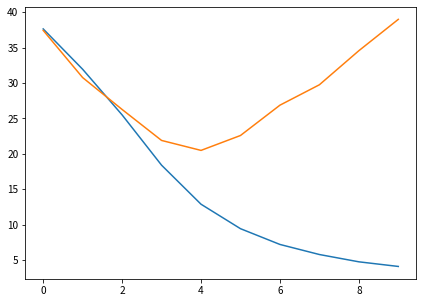

In [14]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(range(len(trainer.train_losses)), trainer.train_losses)
ax.plot(range(len(trainer.val_losses)), trainer.val_losses)
plt.show()

In [19]:
print(trainer.validate(train_loader))
print(trainer.validate(val_loader))

27.23999923070272
27.54495426965138


## 予測結果

In [38]:
model = Conv2dLSTM_Embedding(hid_dim, kernel_size).to(device=device)
model.load_state_dict(torch.load(f'{config.MODEL_DIR}/{model_name}_13.pth'))
model.eval()

NameError: name 'Conv2dLSTM_Embedding' is not defined

In [199]:
def pred_data_generator(X_test, y_test, time_step, prediction_horizon):
    def create(zero_date, pred_start_date, pred_window, sec_id):
        pred_start_ind = int((pd.Timestamp(pred_start_date) - pd.Timestamp(zero_date)).total_seconds() / 
        pred_end_ind = pred_start_ind + pred_window

        in_start_ind = pred_start_ind - prediction_horizon - time_step + 1
        in_end_ind = pred_end_ind
        
        X_in = X_test[:, in_start_ind:in_end_ind, sec_id]
        y_in = y_test[:, in_start_ind:in_end_ind, sec_id]
        y_true = y_test[0, pred_start_ind:pred_end_ind, sec_id]
        
        return X_in, y_in, y_true
    return create

In [200]:
def predict(model, dataset, device=device):
    model.eval()

    with torch.no_grad():
        data, _ = dataset[:]
        if isinstance(data, (list, tuple)):
            data = map(lambda x: x.to(device=device), data)
        else:
            data = data.to(device=device)
        out = model(data).detach().cpu()

    return out

In [239]:
p_gen = pred_data_generator(X_va, y_va, time_step=time_step, prediction_horizon=prediction_horizon)
zero_date = '2022/3/1'

### GW

In [240]:
pred_start_date = '2022/4/29'
pred_window = 9 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [241]:
out = predict(model, dataset_test)

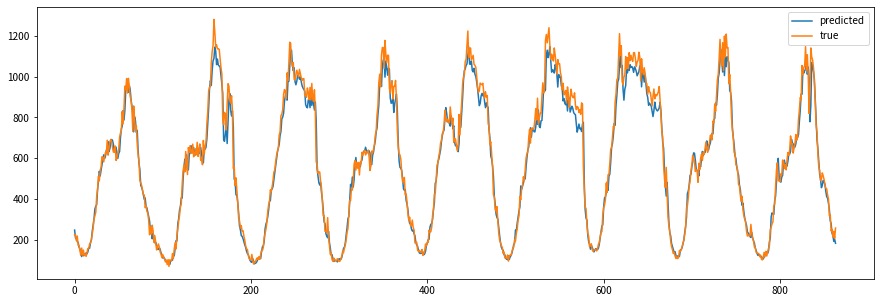

In [242]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

### 普通の1週間 (月~日)

#### 3月

In [228]:
pred_start_date = '2022/3/7'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [229]:
out = predict(model, dataset_test)

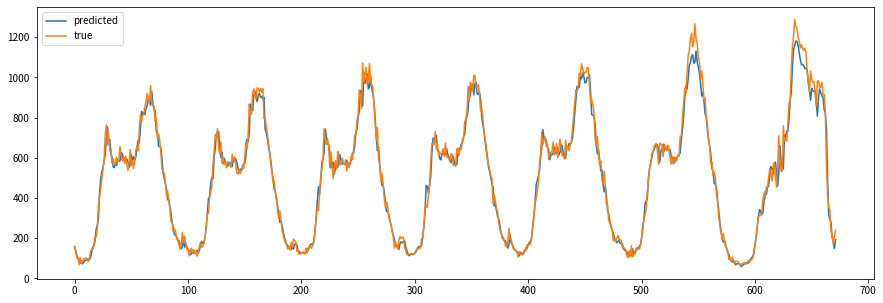

In [231]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 4月

In [233]:
pred_start_date = '2022/4/4'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [234]:
out = predict(model, dataset_test)

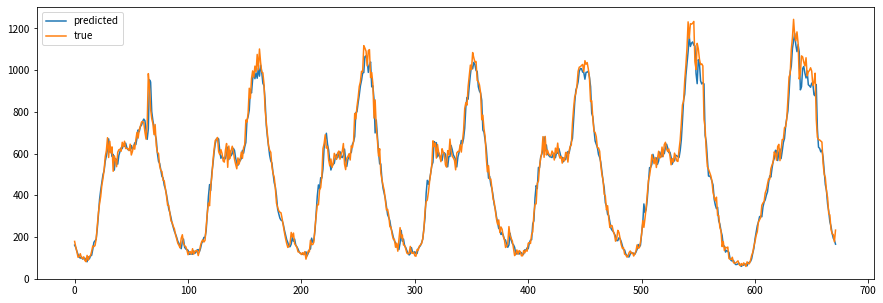

In [235]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()

#### 5月

In [ ]:
pred_start_date = '2022/5/23'
pred_window = 7 * 24 * (60 // 15)

X_in, y_in, y_true = p_gen(zero_date, pred_start_date, pred_window, sec_id=[27])
dataset_test = STDataset(X_in, y_in, 
                         time_step=time_step, 
                         prediction_horizon=prediction_horizon,
                         space_window=space_window, 
                         static_col=static_col)

In [ ]:
out = predict(model, dataset_test)

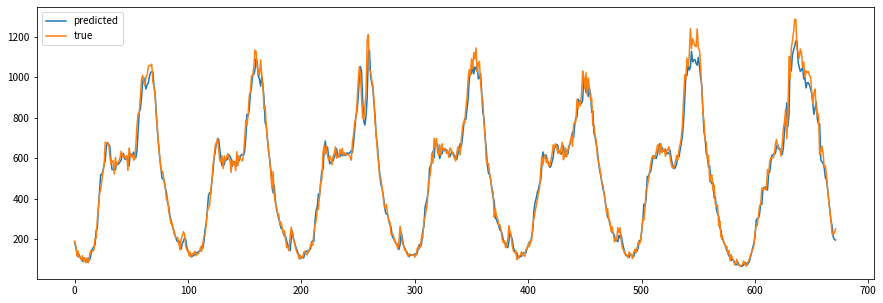

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(range(len(out)), out, label='predicted')
plt.plot(range(len(y_true)), y_true, label='true')
plt.legend()
plt.show()